In [1]:
import os

from typing import Optional, Type, List

from langchain_core.tools import BaseTool
from pydantic import BaseModel, Field

from langchain_google_genai import ChatGoogleGenerativeAI, GoogleGenerativeAIEmbeddings
from langchain_neo4j import Neo4jGraph
from langchain_openai import ChatOpenAI

from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState
from neo4j.time import Date, DateTime

In [2]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "password"

graph = Neo4jGraph(refresh_schema=False)

In [3]:
import getpass

if not os.environ.get("GOOGLE_API_KEY"):
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("GOOGLE_KEY")

GOOGLE_KEY ········


In [11]:
import getpass

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("OPENAI_API_KEY")

OPENAI_API_KEY ········


In [12]:
contract_types = [
    "Affiliate Agreement" "Development",
    "Distributor",
    "Endorsement",
    "Franchise",
    "Hosting",
    "IP",
    "Joint Venture",
    "License Agreement",
    "Maintenance",
    "Manufacturing",
    "Marketing",
    "Non Compete/Solicit" "Outsourcing",
    "Promotion",
    "Reseller",
    "Service",
    "Sponsorship",
    "Strategic Alliance",
    "Supply",
    "Transportation",
]

In [13]:
def convert_neo4j_date(value):
    if isinstance(value, dict):
        return {k: convert_neo4j_date(v) for k, v in value.items()}
    elif isinstance(value, (list, tuple)):
        return [convert_neo4j_date(item) for item in value]
    elif isinstance(value, (Date, DateTime)):
        return f"{value.year}-{value.month}-{value.day}"
    return value

In [14]:
class ContractInput(BaseModel):
    min_effective_date: Optional[str] = Field(None, description="Earliest contract effective date (YYYY-MM-DD)")
    max_effective_date: Optional[str] = Field(None, description="Latest contract effective date (YYYY-MM-DD)")
    min_end_date: Optional[str] = Field(None, description="Earliest contract end date (YYYY-MM-DD)")
    max_end_date: Optional[str] = Field(None, description="Latest contract end date (YYYY-MM-DD)")
    contract_type: Optional[str] = Field(None, description=f"Contract type; valid types: {contract_types}")
    parties: Optional[List[str]] = Field(None, description="List of parties involved in the contract")
    summary_search: Optional[str] = Field(None, description="Inspect summary of the contract")
    country: Optional[str] = Field(None, description="Country where the contract applies")
    active: Optional[bool] = Field(None, description="Whether the contract is active")
    cypher_aggregation: Optional[str] = Field(None, description="""Custom Cypher statement for advanced aggregations and analytics.
    
        This will be appended to the base query:
        ```
        MATCH (c:Contract)
        <filtering based on other parameters>
        WITH c, summary, contract_type, contract_scope, effective_date, end_date, parties, active
        <your cypher goes here>
        ```
        
        Examples:
        
        1. Count contracts by type:
        ```
        RETURN contract_type, count(*) AS count ORDER BY count DESC
        ```
        
        2. Calculate average contract duration by type:
        ```
        WITH contract_type, duration.between(effective_date, end_date).days AS duration
        RETURN contract_type, avg(duration) AS avg_duration ORDER BY avg_duration DESC
        ```
        
        3. Calculate contracts per effective date year:
        ```
        RETURN effective_date.year AS year, count(*) AS count ORDER BY year
        ```
        
        4. Counts the party with the highest number of active contracts:
        ```
        UNWIND parties AS party
        WITH party, active, count(*) AS contract_count
        WHERE active = true
        RETURN party_name, contract_count
        ORDER BY contract_count DESC
        LIMIT 1
        ```
        """)
    

class ContractSearchTool(BaseTool):
    name: str = "ContractSearch"
    description: str = (
        "useful for when you need to answer questions related to any contracts"
    )
    args_schema: Type[BaseModel] = ContractInput

    def _run(
        self,
        min_effective_date: Optional[str] = None,
        max_effective_date: Optional[str] = None,
        min_end_date: Optional[str] = None,
        max_end_date: Optional[str] = None,
        contract_type: Optional[str] = None,
        country: Optional[str] = None,
        parties: Optional[List[str]] = None,
        summary_search: Optional[str] = None,
        active: Optional[bool] = None,
        cypher_aggregation: Optional[str] = None
    ) -> str:
        """Use the tool."""
        return get_contracts(min_effective_date, max_effective_date, min_end_date, max_end_date, contract_type, country, parties,summary_search, active, cypher_aggregation)

In [15]:
embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004")

In [16]:
def get_contracts(
    min_effective_date: Optional[str] = None,
    max_effective_date: Optional[str] = None,
    min_end_date: Optional[str] = None,
    max_end_date: Optional[str] = None,
    contract_type: Optional[str] = None,
    country: Optional[str] = None,
    parties: Optional[List[str]] = None,
    summary_search: Optional[str] = None,
    active: Optional[bool] = None,
    cypher_aggregation: Optional[str] = None
):
    params: dict[str, Any] = {}
    filters: list[str] = []
    cypher_statement = "MATCH (c:Contract) "
    
    # Effective date range
    if min_effective_date:
        filters.append("c.effective_date >= date($min_effective_date)")
        params["min_effective_date"] = min_effective_date
    if max_effective_date:
        filters.append("c.effectiveDate <= date($max_effective_date)")
        params["max_effective_date"] = max_effective_date
    
    # End date range
    if min_end_date:
        filters.append("c.end_date >= date($min_end_date)")
        params["min_end_date"] = min_end_date
    if max_end_date:
        filters.append("c.end_date <= date($max_end_date)")
        params["max_end_date"] = max_end_date
        
    # Contract type
    if contract_type:
        filters.append("c.contract_type IN $contract_type")
        params["contract_type"] = contract_type.split(",")    
    # Country
    if country:
        filters.append("c.country = $country")
        params["country"] = country
    
    # Parties (relationship-based filter)
    if parties:
        parties_filter = []
        for i, party in enumerate(parties):
            party_param_name = f"party_{i}"
            parties_filter.append(f"""EXISTS {{
                MATCH (c)<-[:PARTY_TO]-(party)
                WHERE toLower(party.name) CONTAINS ${party_param_name}
            }}""")
            params[party_param_name] = party.lower()
        
        if parties_filter:
            filters.append(" AND ".join(parties_filter))
    if active is not None:
        operator = ">=" if active else "<"
        filters.append(f"c.end_date {operator} date()")
    if filters:
        cypher_statement += f"WHERE {' AND '.join(filters)} "
    # If summary we use vector similarity
    if summary_search:
        cypher_statement += ("WITH c, vector.similarity.cosine(c.embedding, $embedding) "
                             "AS score ORDER BY score DESC WITH c, score WHERE score > 0.9 ") # Define a threshold limit
        params["embedding"] = embeddings.embed_query(summary_search)
    else: # Else we sort by latest
        cypher_statement += "WITH c ORDER BY c.effective_date DESC "
        
    if cypher_aggregation:
        cypher_statement += """WITH c, c.summary AS summary, c.contract_type AS contract_type, 
          c.contract_scope AS contract_scope, c.effective_date AS effective_date, c.end_date AS end_date,
          [(c)<-[:PARTY_TO]-(party) | party.name] AS parties, c.end_date >= date() AS active """
        cypher_statement += cypher_aggregation
    else:
        # Final RETURN
        cypher_statement += """WITH collect(c) AS nodes
        RETURN {
            total_count_of_contracts: size(nodes),
            example_values: [
              el in nodes[..5] |
              {summary:el.summary, contract_type:el.contract_type, contract_scope: el.contract_scope, file_id: el.file_id, effective_date: el.effective_date, end_date: el.end_date}
            ]
        } AS output"""
    print(cypher_statement)
    output = graph.query(cypher_statement, params)
    return [convert_neo4j_date(el) for el in output]

In [17]:
#llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro") #"gemini-2.0-flash"
llm = ChatOpenAI(model="gpt-4o")
tools = [ContractSearchTool()]
llm_with_tools = llm.bind_tools(tools)

# System message
sys_msg = SystemMessage(
    content="You are a helpful assistant tasked with finding and explaining relevant information about internal contracts."
             "Always explain results you get from the tools in a concise manner to not overwhelm the user"
             "Answer questions as if you are answering to non-technical management level"
)


# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

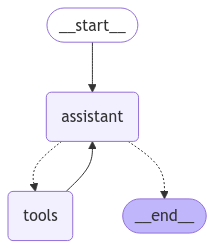

In [18]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [19]:
input_messages = [HumanMessage(content="What are some contracts that ended after 1990-01-01?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

MATCH (c:Contract) WHERE c.end_date >= date($min_end_date) WITH c ORDER BY c.effective_date DESC WITH collect(c) AS nodes
        RETURN {
            total_count_of_contracts: size(nodes),
            example_values: [
              el in nodes[..5] |
              {summary:el.summary, contract_type:el.contract_type, contract_scope: el.contract_scope, file_id: el.file_id, effective_date: el.effective_date, end_date: el.end_date}
            ]
        } AS output
================================ Human Message =================================

What are some contracts that ended after 1990-01-01?
================================== Ai Message ==================================
Tool Calls:
  ContractSearch (call_YwPTV95fDZx2mDSBnLrnIVrh)
 Call ID: call_YwPTV95fDZx2mDSBnLrnIVrh
  Args:
    min_end_date: 1990-01-01
================================= Tool Message =================================
Name: ContractSearch

[{"output": {"total_count_of_contracts": 377, "example_values": [{"summary"

In [20]:
input_messages = [HumanMessage(content="What are some contracts that ended after 1990-01-01 that fall under strategic alliance?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

MATCH (c:Contract) WHERE c.end_date >= date($min_end_date) AND c.contract_type IN $contract_type WITH c ORDER BY c.effective_date DESC WITH collect(c) AS nodes
        RETURN {
            total_count_of_contracts: size(nodes),
            example_values: [
              el in nodes[..5] |
              {summary:el.summary, contract_type:el.contract_type, contract_scope: el.contract_scope, file_id: el.file_id, effective_date: el.effective_date, end_date: el.end_date}
            ]
        } AS output
================================ Human Message =================================

What are some contracts that ended after 1990-01-01 that fall under strategic alliance?
================================== Ai Message ==================================
Tool Calls:
  ContractSearch (call_HouUMc3g5MMLXZmeFx28ZDeQ)
 Call ID: call_HouUMc3g5MMLXZmeFx28ZDeQ
  Args:
    min_end_date: 1990-01-01
    contract_type: Strategic Alliance
================================= Tool Message ====================

In [21]:
input_messages = [HumanMessage(content="What are some contracts with HC2 Holdings, Inc.?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

MATCH (c:Contract) WHERE EXISTS {
                MATCH (c)<-[:PARTY_TO]-(party)
                WHERE toLower(party.name) CONTAINS $party_0
            } WITH c ORDER BY c.effective_date DESC WITH collect(c) AS nodes
        RETURN {
            total_count_of_contracts: size(nodes),
            example_values: [
              el in nodes[..5] |
              {summary:el.summary, contract_type:el.contract_type, contract_scope: el.contract_scope, file_id: el.file_id, effective_date: el.effective_date, end_date: el.end_date}
            ]
        } AS output
================================ Human Message =================================

What are some contracts with HC2 Holdings, Inc.?
================================== Ai Message ==================================
Tool Calls:
  ContractSearch (call_doSdnF6ws7K7Ki2odIeO9Lmc)
 Call ID: call_doSdnF6ws7K7Ki2odIeO9Lmc
  Args:
    parties: ['HC2 Holdings, Inc.']
================================= Tool Message ================================

In [22]:
input_messages = [HumanMessage(content="Which year was the most contracts signed?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()


MATCH (c:Contract) WITH c ORDER BY c.effective_date DESC WITH c, c.summary AS summary, c.contract_type AS contract_type, 
          c.contract_scope AS contract_scope, c.effective_date AS effective_date, c.end_date AS end_date,
          [(c)<-[:PARTY_TO]-(party) | party.name] AS parties, c.end_date >= date() AS active RETURN effective_date.year AS year, count(*) AS count ORDER BY count DESC LIMIT 1
================================ Human Message =================================

Which year was the most contracts signed?
================================== Ai Message ==================================
Tool Calls:
  ContractSearch (call_KKStAhVvcMBJVcBS2jTExEWK)
 Call ID: call_KKStAhVvcMBJVcBS2jTExEWK
  Args:
    cypher_aggregation: RETURN effective_date.year AS year, count(*) AS count ORDER BY count DESC LIMIT 1
================================= Tool Message =================================
Name: ContractSearch

[{"year": 2020, "count": 50}]
================================== Ai Messag

In [23]:
input_messages = [HumanMessage(content="Which company has the most active contracts?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

MATCH (c:Contract) WITH c ORDER BY c.effective_date DESC WITH c, c.summary AS summary, c.contract_type AS contract_type, 
          c.contract_scope AS contract_scope, c.effective_date AS effective_date, c.end_date AS end_date,
          [(c)<-[:PARTY_TO]-(party) | party.name] AS parties, c.end_date >= date() AS active UNWIND parties AS party WITH party, active, count(*) AS contract_count WHERE active = true RETURN party, contract_count ORDER BY contract_count DESC LIMIT 1
================================ Human Message =================================

Which company has the most active contracts?
================================== Ai Message ==================================
Tool Calls:
  ContractSearch (call_bY4ConcS3XWb8ESMp96XsilN)
 Call ID: call_bY4ConcS3XWb8ESMp96XsilN
  Args:
    cypher_aggregation: UNWIND parties AS party WITH party, active, count(*) AS contract_count WHERE active = true RETURN party, contract_count ORDER BY contract_count DESC LIMIT 1
========================

In [24]:
input_messages = [HumanMessage(content="Do we have any contracts about indemnification?")]
messages = react_graph.invoke({"messages": input_messages})
for m in messages["messages"]:
    m.pretty_print()

MATCH (c:Contract) WITH c, vector.similarity.cosine(c.embedding, $embedding) AS score ORDER BY score DESC WITH c, score WHERE score > 0.9 WITH collect(c) AS nodes
        RETURN {
            total_count_of_contracts: size(nodes),
            example_values: [
              el in nodes[..5] |
              {summary:el.summary, contract_type:el.contract_type, contract_scope: el.contract_scope, file_id: el.file_id, effective_date: el.effective_date, end_date: el.end_date}
            ]
        } AS output
================================ Human Message =================================

Do we have any contracts about indemnification?
================================== Ai Message ==================================
Tool Calls:
  ContractSearch (call_tEfxcSL66exUS00ekJGsNFfE)
 Call ID: call_tEfxcSL66exUS00ekJGsNFfE
  Args:
    summary_search: indemnification
================================= Tool Message =================================
Name: ContractSearch

[{"output": {"total_count_of_con